In [1]:
import numpy as np
from k_local import build_local_k
import itertools

Q = np.array([
        [1,0],
        [0,1]
    ])

## Criação da discretização 2D, numeração dos nós e numeração dos elementos

In [2]:
nx = 4
ny = 5
X, Y = np.meshgrid(np.linspace(0,1,nx), np.linspace(0,1,ny))

In [3]:
print(X.shape, Y.shape)

(5, 4) (5, 4)


In [4]:
Z = np.array(list(zip(X.ravel(), Y.ravel())))
print(Z.shape)

(20, 2)


In [5]:
nodes = list(enumerate(Z))
nodes_n = nodes[-1][0] + 1
print(nodes_n)

20


In [6]:
elements_n = (nx-1)*(ny-1)
print(elements_n)

12


In [7]:
G = np.zeros((4,elements_n), dtype=np.int64)

In [8]:
num = 0

for d in range(ny-1):
    for i in range((nx-1)):
        G[:,num] = np.array([i+d*nx, i+1+d*nx, i+nx+1+d*nx, i+nx+d*nx])
        num+=1
        
for x in range(G.shape[1]):
    print(G[:,x])

[0 1 5 4]
[1 2 6 5]
[2 3 7 6]
[4 5 9 8]
[ 5  6 10  9]
[ 6  7 11 10]
[ 8  9 13 12]
[ 9 10 14 13]
[10 11 15 14]
[12 13 17 16]
[13 14 18 17]
[14 15 19 18]


## Montagem da matriz rigidez local, e posterior mapeamento para a matriz rigidez global

In [9]:
def map_nodes_to_physical(G, elem):
    n_ = G[:,elem]
    l = list()
    
    for idx in n_:
        l.append(nodes[int(idx)][1])
        
    M = np.array(l).T
    return M

In [10]:
def l2g(EQ_vector, L2G_matrix, verbose=False):
    #L2G_matrix sera o n_
    nodes_per_elem, elem_n = L2G_matrix.shape
    
    if verbose:
        print(nodes_per_elem, elem_n)
    
    eq_n = int(np.max(EQ_vector) + 1)
    
    if verbose:
        print(eq_n)
    
    K = np.zeros((eq_n, eq_n))
    
    for elem in range(elem_n):
        c = itertools.product(range(nodes_per_elem),repeat=2)
        M = map_nodes_to_physical(L2G_matrix, elem)
        local_k = build_local_k(M, Q)
        
        for x in c:
            aux1 = L2G_matrix[x[0]][elem]
            aux2 = L2G_matrix[x[1]][elem]    
            i = EQ_vector[aux1]
            j = EQ_vector[aux2]
            
            if verbose:
                print('el_node {0} --> glob_node {1} --> eq_vec {2}'.format((x), (aux1, aux2), (i, j)))
                
            if i != -1 and j != -1:
                K[i][j] += local_k[x[0]][x[1]]
                
                if verbose:
                    print('\t----> acumulei no global')
        if verbose:
            print('+'*60)

    return K

In [11]:
EQ_vector = np.zeros((nodes_n,), dtype=np.int64) - 1
count = 0

for idx in range(EQ_vector.shape[0]):
    if idx in [5,6,9,10,13,14]:
        EQ_vector[idx] = count
        count += 1

In [12]:
print(EQ_vector)

[-1 -1 -1 -1 -1  0  1 -1 -1  2  3 -1 -1  4  5 -1 -1 -1 -1 -1]


In [13]:
K = l2g(EQ_vector, G)

In [14]:
for x in K:
    print(x)

[ 2.77777778 -0.05555556 -0.63888889 -0.34722222  0.          0.        ]
[-0.05555556  2.77777778 -0.34722222 -0.63888889  0.          0.        ]
[-0.63888889 -0.34722222  2.77777778 -0.05555556 -0.63888889 -0.34722222]
[-0.34722222 -0.63888889 -0.05555556  2.77777778 -0.34722222 -0.63888889]
[ 0.          0.         -0.63888889 -0.34722222  2.77777778 -0.05555556]
[ 0.          0.         -0.34722222 -0.63888889 -0.05555556  2.77777778]


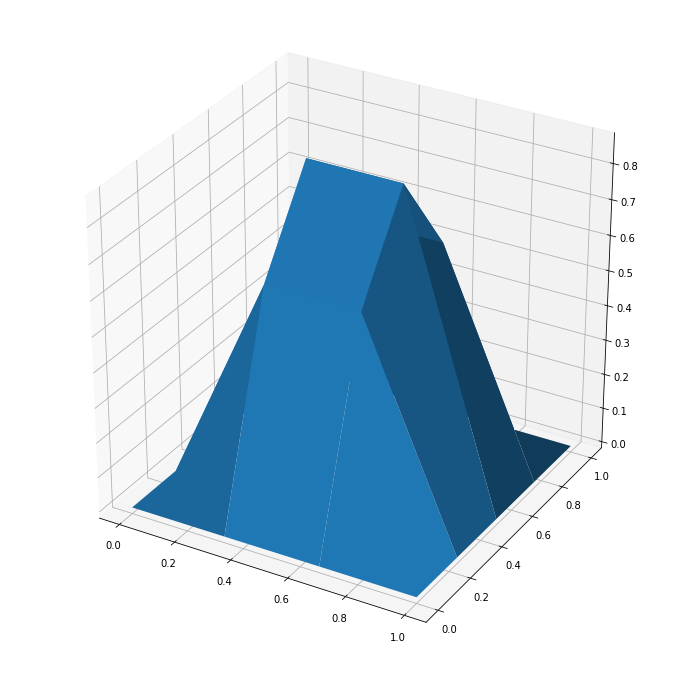

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

Z = np.sin(np.pi*X)*np.sin(np.pi*Y)

ax.plot_surface(X,Y,Z)
plt.show()